# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.music_transformer import *

In [8]:
from src.unilm import *

In [9]:
config = unilm_config(vocab)

In [10]:
# config['bs'] = 2
# config['bptt'] = 1024
# config['n_layers'] = 4
# config['n_heads'] = 4
# config['dec_layers'] = 2

In [11]:
config['n_layers'] = 8
config['dec_layers'] = 0
# config['n_layers'] = 0
# config['dec_layers'] = 8
config['mem_len'] = 512
config['rand_bptt'] = False

In [12]:
config

{'ctx_len': 150,
 'n_layers': 8,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_transpose': True,
 'rand_bptt': False,
 'note_range': (9, 139),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 274,
 'dec_layers': 0}

In [13]:
base_path = Path('../../data/midi/v15/')

In [14]:
cache_name = 'tmp/hook_c'

### Positional encoding experiments

In [51]:

class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d:int):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos:Tensor):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

In [60]:
pos = PositionalEncoding(8)

In [61]:
pos(torch.arange(0, 10, dtype=torch.float))

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  9.9833e-02,  9.9998e-03,  1.0000e-03,  5.4030e-01,
          9.9500e-01,  9.9995e-01,  1.0000e+00],
        [ 9.0930e-01,  1.9867e-01,  1.9999e-02,  2.0000e-03, -4.1615e-01,
          9.8007e-01,  9.9980e-01,  1.0000e+00],
        [ 1.4112e-01,  2.9552e-01,  2.9995e-02,  3.0000e-03, -9.8999e-01,
          9.5534e-01,  9.9955e-01,  1.0000e+00],
        [-7.5680e-01,  3.8942e-01,  3.9989e-02,  4.0000e-03, -6.5364e-01,
          9.2106e-01,  9.9920e-01,  9.9999e-01],
        [-9.5892e-01,  4.7943e-01,  4.9979e-02,  5.0000e-03,  2.8366e-01,
          8.7758e-01,  9.9875e-01,  9.9999e-01],
        [-2.7942e-01,  5.6464e-01,  5.9964e-02,  6.0000e-03,  9.6017e-01,
          8.2534e-01,  9.9820e-01,  9.9998e-01],
        [ 6.5699e-01,  6.4422e-01,  6.9943e-02,  6.9999e-03,  7.5390e-01,
          7.6484e-01,  9.9755e-01,  9.9998e-01],
        [ 9.8936

In [77]:
pos(torch.arange(-100, 1, dtype=torch.float))

tensor([[ 5.0637e-01,  5.4402e-01, -8.4147e-01, -9.9833e-02,  8.6232e-01,
         -8.3907e-01,  5.4030e-01,  9.9500e-01],
        [ 9.9921e-01,  4.5754e-01, -8.3603e-01, -9.8838e-02,  3.9821e-02,
         -8.8919e-01,  5.4869e-01,  9.9510e-01],
        [ 5.7338e-01,  3.6648e-01, -8.3050e-01, -9.7843e-02, -8.1929e-01,
         -9.3043e-01,  5.5702e-01,  9.9520e-01],
        [-3.7961e-01,  2.7176e-01, -8.2489e-01, -9.6848e-02, -9.2515e-01,
         -9.6236e-01,  5.6530e-01,  9.9530e-01],
        [-9.8359e-01,  1.7433e-01, -8.1919e-01, -9.5853e-02, -1.8043e-01,
         -9.8469e-01,  5.7352e-01,  9.9540e-01],
        [-6.8326e-01,  7.5151e-02, -8.1342e-01, -9.4857e-02,  7.3017e-01,
         -9.9717e-01,  5.8168e-01,  9.9549e-01],
        [ 2.4525e-01, -2.4775e-02, -8.0756e-01, -9.3862e-02,  9.6946e-01,
         -9.9969e-01,  5.8979e-01,  9.9559e-01],
        [ 9.4828e-01, -1.2445e-01, -8.0162e-01, -9.2866e-02,  3.1743e-01,
         -9.9223e-01,  5.9783e-01,  9.9568e-01],
        [ 7.7947

## BERT Dataloading

In [15]:
# ns_dl_tfms = [mask_tfm, next_sentence_tfm]
# ns_config = config.copy()
# ns_config['bs'] *= 2
# ns_data = load_music_data(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
#                           y_offset=0, dl_tfms=ns_dl_tfms, **ns_config)

## S2S Dataloading

In [16]:
# s2s_dl_tfms = [mask_s2s_tfm]
# s2s_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
#                            preloader_cls=S2SPreloader, dl_tfms=[mask_s2s_tfm], y_offset=1,
#                            shuffle_dl=True, **config)


### Load NextWord dataset (Language Model)

In [17]:
def nw_enc_tfm(b):
    x,y_nw = b
#     x_mask,y_mask = mask_tfm((x,x), mask_last=True)
#     return (x_mask,torch.full_like(x, TaskType.NextWord.value),x),(y_mask,y_nw) 
    return (x,torch.full_like(x, TaskType.NextWord.value),x),(y_nw,y_nw) 
    

In [18]:
nw_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, 
                              vocab=vocab, dl_tfms=[nw_enc_tfm], y_offset=1, 
                              train_tfms=[to_single_stream], valid_tfms=[to_single_stream], **config)

In [19]:
xb,yb = nw_data.one_batch(cpu=False); 

nw_data.train_dl.dl.dataset.update_rand_bptt()

In [20]:
xb, yb

([tensor([[  8, 143,  76,  ..., 141,   8, 141],
          [  8, 143,  76,  ..., 141,   8, 141],
          [  8, 143,  76,  ..., 141,   8, 141],
          ...,
          [  8, 143,  76,  ..., 141,   8, 141],
          [  8, 143,  76,  ..., 141,   8, 141],
          [  8, 143,  76,  ..., 141,   8, 141]], device='cuda:0'),
  tensor([[4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          ...,
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4]], device='cuda:0'),
  tensor([[  8, 143,  76,  ..., 141,   8, 141],
          [  8, 143,  76,  ..., 141,   8, 141],
          [  8, 143,  76,  ..., 141,   8, 141],
          ...,
          [  8, 143,  76,  ..., 141,   8, 141],
          [  8, 143,  76,  ..., 141,   8, 141],
          [  8, 143,  76,  ..., 141,   8, 141]], device='cuda:0')],
 [tensor([[143,  76, 151,  ...,   8, 141,  88],
          [143,  76, 151,  ...,   8, 141,  88],
         

In [21]:
[x.shape for x in xb+yb]

[torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256])]

## Datasets

In [22]:
# datasets = [ns_data, s2s_data, nw_data]
datasets = [nw_data]

## Load

In [23]:
def predict_func(parts): return [p if idx == 1 else F.softmax(p, dim=-1) for idx,p in enumerate(parts)]
# Need to monkey patch pred_batch activation function for 2d array
loss_func_name = camel2snake(BertLoss.__name__)
basic_train.loss_func_name2activ[loss_func_name] = predict_func

In [24]:
loss_func = BertLoss(loss_mult=(1,0,0,0))
# learn = bert_model_learner(datasets[0], config.copy(), 
#                            loss_func=loss_func)

model = get_bert_model(config['vocab_size'], config=config.copy())
learn = MusicLearner(datasets[0], model, config=config, split_func=None, loss_func=loss_func)

False


In [25]:
learn.metrics = [mask_acc, ns_acc, s2s_acc, nw_acc]

In [26]:
from fastai.callbacks.rnn import RNNTrainer
learn.callbacks = [c for c in learn.callbacks if not isinstance(c, RNNTrainer)]
learn.callbacks.append(BertTrainer(learn, datasets))

In [27]:
[type(c) for c in learn.callbacks]

[src.unilm.BertTrainer]

In [28]:
learn = learn.to_fp16()

In [29]:
learn.model.reset()

### Training

In [30]:
# learn.lr_find(num_it=500)
# learn.recorder.plot()

In [32]:
learn.validate()

[8.275697, tensor(0.), tensor(0), tensor(0), tensor(0.)]

In [33]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,mask_acc,ns_acc,s2s_acc,nw_acc,time
0,0.988468,0.965723,0.701737,0.000000,0.000000,0.000000,02:53


In [34]:
learn.save('sample_train_5')

## Load sample train

In [ ]:
# load_path = base_path/'piano_duet/models/sample_train_5.pth'
# state = torch.load(load_path, map_location='cpu')
# get_model(learn.model).load_state_dict(state['model'])
# load_path

In [ ]:
# learn.load('sample_train')

## Load existing

In [ ]:
saved_models = get_files(base_path/'models/unilm', recurse=True, extensions=['.pth']); saved_models

In [ ]:
# load_path = saved_models[1]
# state = torch.load(load_path, map_location='cpu')
# get_model(learn.model).load_state_dict(state['model'])
# load_path

## Prediction

Prediction algo

In [35]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,7,10,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,song_url,section,numpy,ht_mode,midi,title,ht_time_signature,mxl,ht_offset,ht_bpm,ht_key,md5,midi_title,artist,genres,parts,source
193179,https://www.hooktheory.com/theorytab/view/ritc...,chorus,piano_duet/hooktheory/pianoroll/r/ritchie-vale...,1.0,midi_sources/hooktheory/pianoroll/r/ritchie-va...,la-bamba,4.0,NaN,0.0,144.0,C,aeee134e4034e5f98bb630c56d2f7f8c,La Bamba,ritchie-valen,"Pop,Rock",chorus,hooktheory_c


In [36]:
idx = 0
file = base_path/results.numpy.values[idx];
orig = base_path/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [37]:
seed_len = 40
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np, vocab=vocab))[None]
if torch.cuda.is_available(): xb = xb.cuda()

In [38]:
# seed_stream = npenc2stream(seed_np)
# seed_stream.show()

In [39]:
xb

tensor([[  0,   1,   8, 150,  64, 141,   8, 141,  66, 141,   8, 141,  68, 141,
           8, 141,  69, 143,  64, 147,  61, 147,  57, 147,   8, 143,  73, 141,
           8, 141,  76, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  74, 141,   8, 141,  78, 141,   8, 141,  76, 143,   8, 141,
          59, 147,  56, 147,  52, 147,   8, 141,  64, 141,   8, 141,  68, 141,
           8, 141,  71, 141,   8, 141,  74, 141,  69, 147,  66, 147]],
       device='cuda:0')

In [40]:
task_type = torch.full_like(xb, TaskType.NextWord.value)
# res = self.pred_batch(batch=((xb,task_type,xb),(xb)))[-1][0, -1] # task1, task2 - (bs x ts x vocab)

In [41]:
learn.model.reset()

In [42]:
res = learn.pred_batch(batch=((xb,task_type,xb),xb)); res

[tensor([[[2.5081e-03, 1.0378e-04, 1.6933e-05,  ..., 5.0256e-05,
           3.7347e-05, 4.7815e-05],
          [5.7139e-04, 6.5287e-04, 6.8912e-05,  ..., 2.0254e-04,
           1.9593e-04, 1.8015e-04],
          [1.5790e-06, 2.1452e-04, 2.1251e-05,  ..., 7.0432e-05,
           6.2704e-05, 5.4799e-05],
          ...,
          [6.7296e-06, 1.2831e-06, 1.0091e-06,  ..., 1.5119e-06,
           1.2196e-06, 1.2932e-06],
          [1.1424e-07, 1.9169e-07, 2.7512e-07,  ..., 2.2719e-07,
           3.1358e-07, 3.8346e-07],
          [8.2934e-06, 4.6136e-07, 7.2724e-07,  ..., 4.9594e-07,
           4.3681e-07, 3.5030e-07]]]),
 tensor([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4, 4, 4, 4, 4]]),
 tensor([[[0.0062, 0.0036, 0.0037,  ..., 0.0036, 0.0037, 0.0037],
          [0.0034, 0.

In [43]:
preds = loss_batch(learn.model.eval(), (xb,task_type,xb), yb); preds

([tensor([[[-3.5566, -4.9961, -4.6055,  ..., -5.0547, -4.6953, -4.7656],
           [ 3.5547, -2.4277, -3.8398,  ..., -3.6152, -3.3496, -3.4199],
           [-5.6562, -1.5762, -2.6035,  ..., -2.0977, -2.2500, -2.4375],
           ...,
           [-0.8667, -2.6602, -2.8965,  ..., -2.5078, -2.7031, -2.6074],
           [-4.1641, -3.8730, -3.5059,  ..., -3.7129, -3.3750, -3.1230],
           [-0.2939, -3.1094, -2.6914,  ..., -3.0625, -3.2266, -3.3887]]],
         dtype=torch.float16),
  tensor([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
           4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
           4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
           4, 4, 4, 4, 4, 4, 4, 4, 4, 4]]),
  tensor([[[ 0.5522,  0.0147,  0.0298,  ...,  0.0086,  0.0257,  0.0343],
           [ 0.0147,  0.4268,  0.1171,  ...,  0.1293,  0.1470,  0.1415],
           [ 0.2771, -0.0692, -0.0964,  ..., -0.1090, -0.0880, -0.0962],
 

In [44]:
# last = res[-1][0, -1]; last[143]
# idx = torch.multinomial(res[-1][0, -1], 1).item(); idx

In [45]:

def predict_nw(self, xb:Tensor, n_words:int=128):
    if xb.shape[0] > 1: xb = xb[0][None]
    seed = xb.cpu().numpy().squeeze()
    yb = torch.ones_like(xb)
    new_idx = []
#     self.mask = False
    self.model.reset()

    for i in progress_bar(range(n_words), leave=True):
        print(xb)
        task_type = torch.full_like(xb, TaskType.NextWord.value)
        
        # Masking last - bert
#         mask_last = torch.cat((xb, torch.tensor(vocab.mask_idx, device=xb.device).view(1, 1)), dim=-1)
#         res = self.pred_batch(batch=((mask_last,task_type,mask_last),(yb)))[0][0, -1] # task1, task2 - (bs x ts x vocab)
        
        # Next Word
#         res = self.pred_batch(batch=((xb,task_type,xb),xb))[-1][0, -1] # task1, task2 - (bs x ts x vocab)

        # Encoder only - nw
        res = self.pred_batch(batch=((xb,task_type,xb),xb))[0][0, -1] # task1, task2 - (bs x ts x vocab)

        # Use first temperatures value if last prediction was duration
        res.pow_(1 / (0.5))

        idx = torch.multinomial(res, 1).item()
    
        new_idx.append(idx)
#         t_idx = torch.tensor(idx, device=xb.device).view(1, 1)
#         xb = torch.cat((xb, t_idx), dim=-1)
        xb = xb.new_tensor([idx])[None]
        
#     self.mask = True
    return np.array(new_idx), seed


In [46]:
# vocab.itos[143]

In [47]:
if xb.shape[0] > 1: xb = xb[0][None]
seed = xb.cpu().numpy().squeeze()
yb = torch.ones_like(xb)
res = learn.pred_batch(batch=((xb, torch.full_like(xb, TaskType.NextWord.value),xb),(yb)))
res[-1][0, -1][141]

tensor(0.0044)

In [48]:
out_s, seed_s = predict_nw(learn, xb, n_words=40)

tensor([[  0,   1,   8, 150,  64, 141,   8, 141,  66, 141,   8, 141,  68, 141,
           8, 141,  69, 143,  64, 147,  61, 147,  57, 147,   8, 143,  73, 141,
           8, 141,  76, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  74, 141,   8, 141,  78, 141,   8, 141,  76, 143,   8, 141,
          59, 147,  56, 147,  52, 147,   8, 141,  64, 141,   8, 141,  68, 141,
           8, 141,  71, 141,   8, 141,  74, 141,  69, 147,  66, 147]],
       device='cuda:0')
tensor([[62]], device='cuda:0')
tensor([[147]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[141]], device='cuda:0')
tensor([[76]], device='cuda:0')
tensor([[141]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[141]], device='cuda:0')
tensor([[76]], device='cuda:0')
tensor([[141]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[141]], device='cuda:0')
tensor([[76]], device='cuda:0')
tensor([[141]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[141]], device='cud

In [49]:
[vocab.itos[i] for i in out_s]

['n53',
 'd8',
 'xxsep',
 'd2',
 'n67',
 'd2',
 'xxsep',
 'd2',
 'n67',
 'd2',
 'xxsep',
 'd2',
 'n67',
 'd2',
 'xxsep',
 'd2',
 'n67',
 'd2',
 'xxsep',
 'd2',
 'n67',
 'd2',
 'n50',
 'd8',
 'n47',
 'd8',
 'n43',
 'd8',
 'xxsep',
 'd2',
 'n67',
 'd2',
 'xxsep',
 'd2',
 'n67',
 'd2',
 'xxsep',
 'd2',
 'n67',
 'd2']

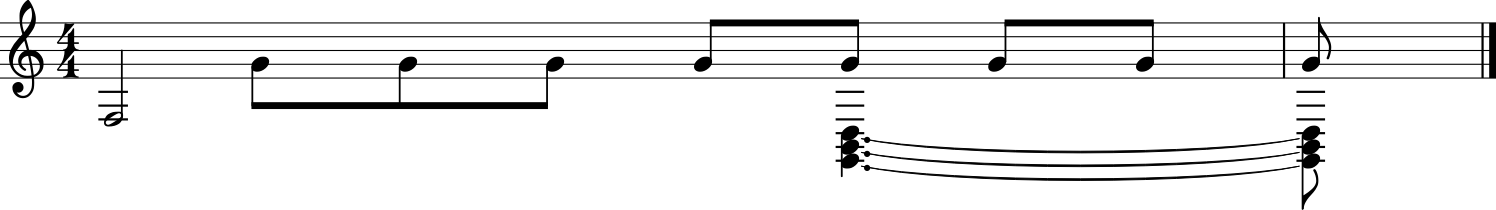

In [50]:
stream = npenc2stream(to_double_stream(out_s))
stream.show()